In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from concurrent.futures import ThreadPoolExecutor


In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch


In [4]:
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")


In [5]:
# Temporary session memory
session_memory = {}

# Long-term memory
memory_bank = {}


In [6]:
scholarship_df = pd.read_csv("dataset/Scholarship-Data.csv")
logging.info("Scholarship dataset loaded successfully")


2025-11-17 21:42:15,108 [INFO] Scholarship dataset loaded successfully


In [7]:
# Quick look at the data
print(scholarship_df.head())

                name degree  min_gpa                                 keywords  \
0  MSc Scholarship 1    MSc     3.77                             art,computer   
1  MSc Scholarship 2    MSc     3.70  robotics,research,programming,analytics   
2  PhD Scholarship 3    PhD     3.22          data,design,computer,creativity   
3   BA Scholarship 4     BA     2.60      analytics,programming,management,AI   
4  MBA Scholarship 5    MBA     3.31               leadership,tech,management   

                                   url  
0  https://example.com/scholarship_001  
1  https://example.com/scholarship_002  
2  https://example.com/scholarship_003  
3  https://example.com/scholarship_004  
4  https://example.com/scholarship_005  


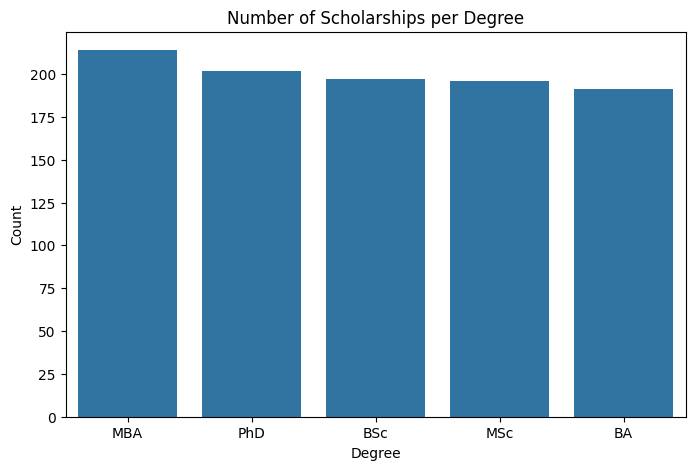

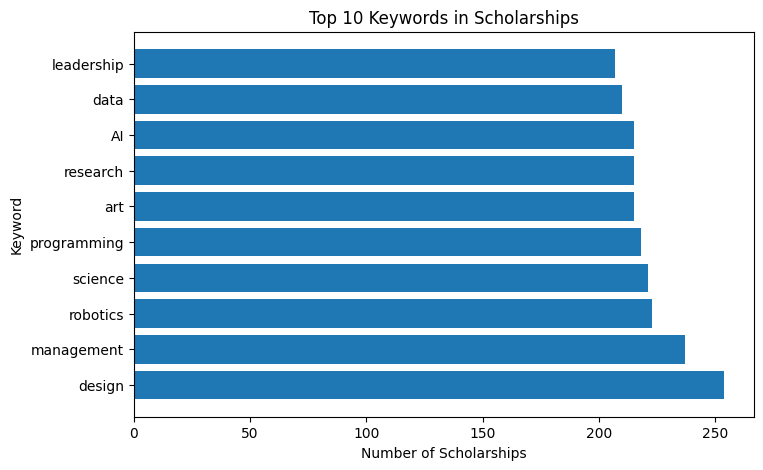

In [12]:
# Scholarships per Degree
plt.figure(figsize=(8,5))
sns.countplot(data=scholarship_df, x='degree', order=scholarship_df['degree'].value_counts().index)
plt.title("Number of Scholarships per Degree")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

# Top 10 keywords
all_keywords = []
for kws in scholarship_df['keywords']:
    all_keywords.extend([k.strip() for k in str(kws).split(',')])

keyword_counts = Counter(all_keywords)
keys, counts = zip(*keyword_counts.most_common(10))

plt.figure(figsize=(8,5))
plt.barh(keys, counts)
plt.title("Top 10 Keywords in Scholarships")
plt.xlabel("Number of Scholarships")
plt.ylabel("Keyword")
plt.show()


In [13]:
def intake_agent():
    print("Welcome to AI Scholarship Assistant!\n")
    
    student_name = input("Enter your name: ")
    degree = input("Enter your degree program: ")
    gpa = float(input("Enter your GPA: "))
    skills = input("Enter your skills (comma separated): ").split(',')
    interests = input("Enter your areas of interest (comma separated): ").split(',')
    
    student_profile = {
        "name": student_name,
        "degree": degree,
        "gpa": gpa,
        "skills": [s.strip() for s in skills],
        "interests": [i.strip() for i in interests]  # ← IMPORTANT
    }

    session_memory[student_name] = student_profile
    memory_bank[student_name] = student_profile

    print(f"\nProfile for {student_name} saved!\n")
    return student_profile

In [14]:
def match_scholarships(student_profile, df):
    logging.info("Matching scholarships...")
    student_interests = [i.lower() for i in student_profile['interests']]
    eligible_scholarships = []

    for _, row in df.iterrows():
        keywords = [k.lower().strip() for k in str(row['keywords']).split(',')]
        if any(i in keywords for i in student_interests) and student_profile['gpa'] >= float(row['min_gpa']):
            eligible_scholarships.append(row)

    if not eligible_scholarships:
        logging.info("No exact matches found, showing top 5 closest scholarships...")
        df['overlap'] = df['keywords'].apply(
            lambda x: len(set([k.lower().strip() for k in str(x).split(',')]) & set(student_interests))
        )
        top5 = df.sort_values('overlap', ascending=False).head(5)
        for _, row in top5.iterrows():
            eligible_scholarships.append(row)

    logging.info(f"Found {len(eligible_scholarships)} matched scholarships.")
    return eligible_scholarships


In [16]:
MODEL_NAME = "distilgpt2"  # Lightweight GPT model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float32,
    device_map="auto" if torch.cuda.is_available() else None
)


In [17]:
def generate_sop(student_profile, scholarship_name):
    prompt = f"""
    Write a strong Statement of Purpose for {student_profile['name']} 
    pursuing {student_profile['degree']} with GPA {student_profile['gpa']}.
    Skills: {', '.join(student_profile['skills'])}.
    Interests: {', '.join(student_profile['interests'])}.
    Applying for scholarship: {scholarship_name}.
    """
    inputs = tokenizer(prompt, return_tensors="pt")
    output = model.generate(**inputs, max_new_tokens=250, no_repeat_ngram_size=3)
    sop = tokenizer.decode(output[0], skip_special_tokens=True)
    return sop


In [24]:
def evaluate_sop(sop_text, scholarship_keywords):
    sop_words = set(sop_text.lower().split())
    keyword_words = set([k.lower().strip() for k in scholarship_keywords.split(',')])
    score = len(sop_words & keyword_words) / max(len(keyword_words), 1) * 100
    return round(score, 2)

In [25]:
def run_workflow(student_profile, df):
    matched = match_scholarships(student_profile, df)
    results = []

    if not matched:
        logging.info("No scholarships matched. [End / No Eligible Scholarships]")
        return pd.DataFrame()

    logging.info("Generating SOPs for matched scholarships...")

    def process_scholarship(s):
        sop = generate_sop(student_profile, s['name'])
        score = evaluate_sop(sop, s['keywords'])
        filename = f"{student_profile['name'].replace(' ','_')}_{s['name'].replace(' ','_')}_SOP.txt"
        with open(filename, "w", encoding="utf-8") as f:
            f.write(sop)
        return {
            "scholarship": s['name'],
            "degree": s['degree'],
            "min_gpa": s['min_gpa'],
            "sop_score": score,
            "sop_file": filename
        }

    # Parallel execution for speed
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(process_scholarship, matched))

    logging.info("SOP generation completed. [End / Application Ready]")
    return pd.DataFrame(results)


In [ ]:
if __name__ == "__main__":
    student_profile = intake_agent()
    df_results = run_workflow(student_profile, scholarship_df)

    if not df_results.empty:
        print("\n===== MATCHED SCHOLARSHIPS & GENERATED SOPs =====\n")
        display(df_results)
    else:
        print("\nNo matched scholarships or SOPs generated.")


Welcome to AI Scholarship Assistant!



2025-11-17 22:17:42,946 [INFO] Matching scholarships...



Profile for Mohisa Maharjan saved!



2025-11-17 22:17:43,183 [INFO] Found 347 matched scholarships.
2025-11-17 22:17:43,184 [INFO] Generating SOPs for matched scholarships...
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation